# Plausible values

[What are plausible values and why are they useful](https://www.ierinstitute.org/fileadmin/Documents/IERI_Monograph/IERI_Monograph_Volume_02_Chapter_01.pdf)
- the article advocates using plausible values and confirms that using averages of plausible values leads to correct point estimates, but biased standard errors
- as we use the scores as predictors in regression, it would be safer to handle the plausible values correctly - what does it mean in our case?
- the article suggests to calculate statistics based on various plausible values and then taking the means of different calculations - we can try this easily, to get some feel for the impact on the estimates

**S použitím plausible values tento notebook jen opakuje analýzu z předchozího notebooku 2021-09-20_prisnost-znamkovani-v2**

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
#plt.ioff()

In [2]:
# cesta k datum
data_root = '/mnt/d/projects/idea/data'

In [3]:
# načtení dat - obecně data k mezinárodním vzdělávacím studiím jsou ve formátu .sav pro SPSS
# v SPSS existuje i plugin pro korektní práci s plausible values, nicméně pro naše účely není potřeba
# - pro bodové odhady by mělo stačit zprůměrování plausible values; navíc nemám SPSS...
sg11, sg11_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2011/CZ/T11_dot_zak.sav')
sg15, sg15_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2015/CZ/ASGCZEM6.sav')

In [4]:
# takto vypadjí raw data
sg11

,IDCNTRY,IDBOOK,IDSCHOOL,IDCLASS,IDSTUD,IDGRADE,ITBIRTHD,ITBIRTHM,ITBIRTHY,ITSEX,...,o07b,o07c,o07d,o08a,o08b,o08c,o08d,o08e,o08f,o13
0,203.0,8.0,1.0,102.0,10201.0,4.0,23.0,10.0,2000.0,2.0,...,1.0,1.0,2.0,4.0,4.0,3.0,2.0,1.0,3.0,4.0
1,203.0,9.0,1.0,102.0,10202.0,4.0,4.0,5.0,2001.0,2.0,...,2.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,2.0,4.0
2,203.0,10.0,1.0,102.0,10203.0,4.0,14.0,12.0,1999.0,2.0,...,1.0,2.0,2.0,4.0,3.0,1.0,1.0,3.0,1.0,4.0
3,203.0,11.0,1.0,102.0,10204.0,4.0,13.0,2.0,2001.0,2.0,...,2.0,2.0,2.0,3.0,3.0,4.0,2.0,1.0,2.0,2.0
4,203.0,12.0,1.0,102.0,10205.0,4.0,19.0,7.0,2001.0,2.0,...,2.0,2.0,2.0,4.0,3.0,3.0,4.0,1.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,203.0,2.0,2167.0,216702.0,21670221.0,4.0,28.0,7.0,2001.0,2.0,...,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,4.0,3.0
4574,203.0,3.0,2167.0,216702.0,21670222.0,4.0,10.0,9.0,2000.0,1.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,4.0
4575,203.0,4.0,2167.0,216702.0,21670223.0,4.0,6.0,9.0,2001.0,1.0,...,1.0,1.0,2.0,3.0,3.0,2.0,2.0,1.0,4.0,3.0
4576,203.0,5.0,2167.0,216702.0,21670224.0,4.0,18.0,10.0,2000.0,2.0,...,2.0,2.0,2.0,2.0,3.0,3.0,2.0,1.0,3.0,4.0


In [5]:
# vyber jen užitečné proměnné, vynech nesmyslné známky, napočítej průměry přes plausible values pro mat a sci

shared_cols = {
    'IDSCHOOL': 'school',
    'IDCLASS': 'class',
    'IDSTUD': 'student',
    'ITSEX': 'girl',
    'TOTWGT': 'weight',
    **{f'ASMMAT0{i}': f'mat_pv{i}' for i in range(1, 6)},
    **{f'ASSSCI0{i}': f'sci_pv{i}' for i in range(1, 6)}
}

cols11 = {**shared_cols, 'o02c': 'mat_grade', 'o02d': 'sci_grade' }
cols15 = {**shared_cols, 'ASXG20C': 'mat_grade', 'ASXG20D': 'sci_grade' }

sg11 = sg11[cols11.keys()].rename(columns=cols11)
sg15 = sg15[cols15.keys()].rename(columns=cols15)

for c in ['school', 'class', 'student', 'girl']:
    sg11[c] = pd.Series(sg11[c], dtype=np.int_)
    sg15[c] = pd.Series(sg15[c], dtype=np.int_)

sg11['girl'] = -sg11['girl'] + 2
sg15['girl'] = -sg15['girl'] + 2

for c in ['mat', 'sci']:
    sg11[c + '_grade'] = np.where(sg11[c + '_grade'] > 5, np.nan, sg11[c + '_grade'])
    sg15[c + '_grade'] = np.where(sg15[c + '_grade'] > 5, np.nan, sg15[c + '_grade'])
    sg11[c] = np.mean(sg11[[f'{c}_pv{i}' for i in range(1, 6)]], axis=1)
    sg15[c] = np.mean(sg15[[f'{c}_pv{i}' for i in range(1, 6)]], axis=1)
    #sg11 = sg11.drop(columns=[f'{c}_pv{i}' for i in range(1, 6)])
    #sg15 = sg15.drop(columns=[f'{c}_pv{i}' for i in range(1, 6)])

sg11['unit'] = 1
sg15['unit'] = 1

In [6]:
# z dat vyberu jen co potřebuji a plausible values nahrazuji průměrem
sg11

,school,class,student,girl,weight,mat_pv1,mat_pv2,mat_pv3,mat_pv4,mat_pv5,sci_pv1,sci_pv2,sci_pv3,sci_pv4,sci_pv5,mat_grade,sci_grade,mat,sci,unit
0,1,102,10201,0,13.344744,603.15454,634.98035,611.82447,608.84376,614.53425,673.50420,675.62888,638.74131,613.60817,630.46276,1.0,1.0,614.667474,646.389064,1
1,1,102,10202,0,13.344744,559.66132,575.56972,631.88314,567.37784,593.60812,665.62351,670.10692,668.35382,619.85676,669.59668,1.0,1.0,585.620028,658.707538,1
2,1,102,10203,0,13.344744,439.09259,513.68623,453.10759,499.17209,469.68880,463.72893,470.09666,483.94261,461.61703,414.07610,3.0,2.0,474.949460,458.692266,1
3,1,102,10204,0,13.344744,532.56474,511.43531,540.09394,527.37176,490.62200,499.39774,557.83561,485.60474,488.41180,508.34360,1.0,1.0,520.417550,507.918698,1
4,1,102,10205,0,13.344744,515.37553,465.65073,510.38848,510.46161,445.49805,527.48251,550.72745,567.21269,610.98112,530.59479,3.0,1.0,489.474880,557.399712,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4573,2167,216702,21670221,0,4.385031,539.47922,528.38615,531.30969,541.87152,516.62725,553.58637,526.95944,551.23856,529.47639,544.91045,1.0,1.0,531.534766,541.234242,1
4574,2167,216702,21670222,1,4.385031,627.99670,652.16418,623.36352,677.52645,639.53744,643.59867,650.03368,570.59181,676.72894,603.72347,1.0,1.0,644.117658,628.935314,1
4575,2167,216702,21670223,1,4.385031,489.37995,588.72766,559.51900,588.41711,585.35519,520.47773,600.52885,543.73801,587.82694,572.07686,1.0,1.0,562.279782,564.929678,1
4576,2167,216702,21670224,0,4.385031,480.72273,477.71254,502.68211,548.85110,501.34217,511.45999,505.09942,579.50499,555.27571,549.15142,2.0,3.0,502.262130,540.098306,1


In [7]:
cg15, cg15_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2015/CZ/ACGCZEM6.sav')
cg11, cg11_meta = pyreadstat.read_sav(f'{data_root}/TIMSS/2011/CZ/T11_dot_skolni.sav')

cg15['school'] = np.int_(cg15['IDSCHOOL'])
cg11['school'] = np.int_(cg11['IDSCHOOL'])

In [8]:
cg11

,IDCNTRY,IDSCHOOL,ACBG01,ACBG02,ACBG03A,ACBG03B,ACBG04,ACBG05A,ACBG05B,ACBG05C,...,ACDGEAS,ACBGDAS,ACDGDAS,ACDG03,ACDGENS,ACDG09,ACDGCMP,ACDG06HY,ACDG06,school
0,203.0,1.0,693.0,74.0,2.0,2.0,1.0,1.0,2.0,2.0,...,3.0,9.45643,2.0,2.0,4.0,1.0,1.0,727.50,5.0,1
1,203.0,2.0,613.0,66.0,3.0,3.0,1.0,1.0,2.0,1.0,...,2.0,9.14425,2.0,2.0,1.0,1.0,2.0,NaN,5.0,2
2,203.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3
3,203.0,4.0,339.0,33.0,2.0,1.0,2.0,1.0,1.0,3.0,...,3.0,10.17820,1.0,2.0,4.0,2.0,1.0,731.25,5.0,4
4,203.0,5.0,463.0,60.0,2.0,2.0,1.0,1.0,2.0,2.0,...,3.0,8.86115,2.0,2.0,4.0,2.0,2.0,837.25,5.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,203.0,2012.0,81.0,8.0,NaN,NaN,1.0,6.0,5.0,3.0,...,2.0,9.45643,2.0,NaN,4.0,2.0,1.0,843.75,5.0,2012
173,203.0,2100.0,37.0,8.0,4.0,2.0,1.0,6.0,5.0,2.0,...,2.0,11.81833,1.0,3.0,3.0,3.0,1.0,776.25,5.0,2100
174,203.0,2119.0,364.0,37.0,1.0,3.0,1.0,5.0,4.0,2.0,...,2.0,9.45643,2.0,1.0,4.0,4.0,1.0,806.25,5.0,2119
175,203.0,2154.0,110.0,26.0,4.0,1.0,2.0,4.0,4.0,3.0,...,3.0,11.81833,1.0,3.0,4.0,4.0,1.0,712.50,5.0,2154


In [10]:
%%javascript
/*** To fix for equation numbering in latex ***/
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [12]:
def get_weighted_means(frame, weight_col='weight', cols=None):
    """
    Calculates weighted means of dataframe columns.
    
    :param frame: Input dataframe.
    :param weight_col: Column containing weights.
    :param cols: Columns to calculate the weighted means of. If not provided, use all non-weight columns.
    :return: Series with weighted means, keyed by column names.
    """
    res = pd.Series(dtype='float64')
    for c in cols or frame.columns[frame.columns != weight_col]:
        res[c] = (frame[c] * frame[weight_col]).sum() / frame[weight_col].sum()
    return res

def get_fixed_effects(df, group_col, grade_col, score_col, girl_col='girl', weight_col='weight'):
    df = df[[group_col, grade_col, score_col, girl_col, weight_col]].dropna().copy()
    
    # pomocí DescrStatsW získáme vážené průměry i směrodatné odchylky
    stats_grade = DescrStatsW(df[grade_col], weights=df[weight_col])
    stats_score = DescrStatsW(df[score_col], weights=df[weight_col])

    # převod na z-skóry, aby následně parametry bylo možné interpretovat ve směrodatných odchylkách
    # chci z-skóry i u známek? - asi ne, známky jsou zde snadněji interpretovatelné
    df[score_col] = (df[score_col] - stats_score.mean) / stats_score.std
    # df[grade_col] = -(df[grade_col] - stats_grade.mean) / stats_grade.std

    cols = [grade_col, score_col, girl_col]
    
    # c_means dataframe obsahuje skupinové průměry
    c_means = df.groupby(group_col).apply(get_weighted_means, weight_col=weight_col, cols=cols).reset_index()
    df = pd.merge(df, c_means.rename(columns={c: c + '_cm' for c in cols}))
    for c in cols:
        # _adj sloupce jsou proměnné pro odhad rovnice (4)
        df[c + '_adj'] = df[c] - df[c + '_cm'] + np.average(df[c], weights=df[weight_col])

    # WLS ze statsmodels je Weighted Least Squares
    model = sm.WLS(df[grade_col + '_adj'], sm.add_constant(df[[score_col + '_adj', girl_col + '_adj']]), weights=df[weight_col]).fit()

    # zpětným dosazením napočítáme \mu_i (označené jako fe pro fixed effects)
    c_means['fe'] = c_means[grade_col] - model.params['const'] \
        - model.params[score_col + '_adj'] * c_means[score_col] \
        - model.params[girl_col + '_adj'] * c_means[girl_col]
    c_means['count'] = df.groupby(group_col)[grade_col].count().values

    # a vrátíme dataframe s indexem skupiny, fixed effects a počtem žáků ve skupinách
    return c_means[[group_col, 'fe', 'count']]

def get_fixed_effects_pv(df, group_col, grade_col, score_col, girl_col='girl', weight_col='weight'):
    # use plausible values instead of the average scores
    # suffix score_col with _pvX, then calculate FE and suffix them appropriately
    # the final result contains fe_pvX and their average fe
    
    res = get_fixed_effects(df, group_col, grade_col, f'{score_col}_pv1', girl_col, weight_col)
    res['fe_pv1'] = res['fe']
    res = res.drop(columns=['fe'])
    for i in range(2, 6):
        res_next = get_fixed_effects(df, group_col, grade_col, f'{score_col}_pv{i}', girl_col, weight_col)
        res = pd.merge(res, res_next.drop(columns=['count']).rename(columns={'fe': f'fe_pv{i}'}))
    
    res['fe'] = np.mean(res[[f'fe_pv{i}' for i in range(1, 6)]], axis=1)
    return res        

## Plausible values for fixed effects

In [13]:
fe15_mat = get_fixed_effects_pv(sg15, 'school', 'mat_grade', 'mat')
fe15_sci = get_fixed_effects_pv(sg15, 'school', 'sci_grade', 'sci')
fe11_mat = get_fixed_effects_pv(sg11, 'school', 'mat_grade', 'mat')
fe11_sci = get_fixed_effects_pv(sg11, 'school', 'sci_grade', 'sci')

fe15_mat_class = get_fixed_effects_pv(sg15, 'class', 'mat_grade', 'mat')
fe15_sci_class = get_fixed_effects_pv(sg15, 'class', 'sci_grade', 'sci')
fe11_mat_class = get_fixed_effects_pv(sg11, 'class', 'mat_grade', 'mat')
fe11_sci_class = get_fixed_effects_pv(sg11, 'class', 'sci_grade', 'sci')

/mnt/d/projects/idea/code/venv/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
fe15_mat

,school,count,fe_pv1,fe_pv2,fe_pv3,fe_pv4,fe_pv5,fe
0,1,41,-0.022930,-0.003307,0.001216,-0.020593,-0.006422,-0.010407
1,2,46,0.329700,0.328379,0.342595,0.270393,0.323261,0.318866
2,3,26,0.022954,-0.023421,-0.041476,-0.071382,0.007752,-0.021115
3,4,32,-0.129077,-0.070674,-0.131047,-0.127233,-0.096469,-0.110900
4,5,11,-0.527412,-0.513389,-0.514706,-0.527231,-0.514750,-0.519498
...,...,...,...,...,...,...,...,...
153,155,40,-0.444470,-0.412593,-0.410872,-0.418009,-0.423159,-0.421821
154,156,55,-0.134635,-0.082409,-0.096558,-0.127093,-0.086902,-0.105519
155,157,44,-0.157226,-0.133855,-0.159538,-0.160509,-0.203830,-0.162991
156,158,7,0.428820,0.337149,0.288334,0.339516,0.312052,0.341174


**Zkontroluj, jak jsou spolu korelované jednotlivé plausible values; potom zopakuj analýzu na průměrech koeficientů.**

Ok, všechny korelogramy ukazují, že FE spočítané z různých plausible values se velmi dobře shodují. Klidně tedy mohu použít průměrný FE po použití různých plausible values, nepřináší to moc komplexity a je to korektnější postup.

fe11_mat
fe11_sci
fe15_mat
fe15_sci
fe11_mat_class
fe11_sci_class
fe15_mat_class
fe15_sci_class


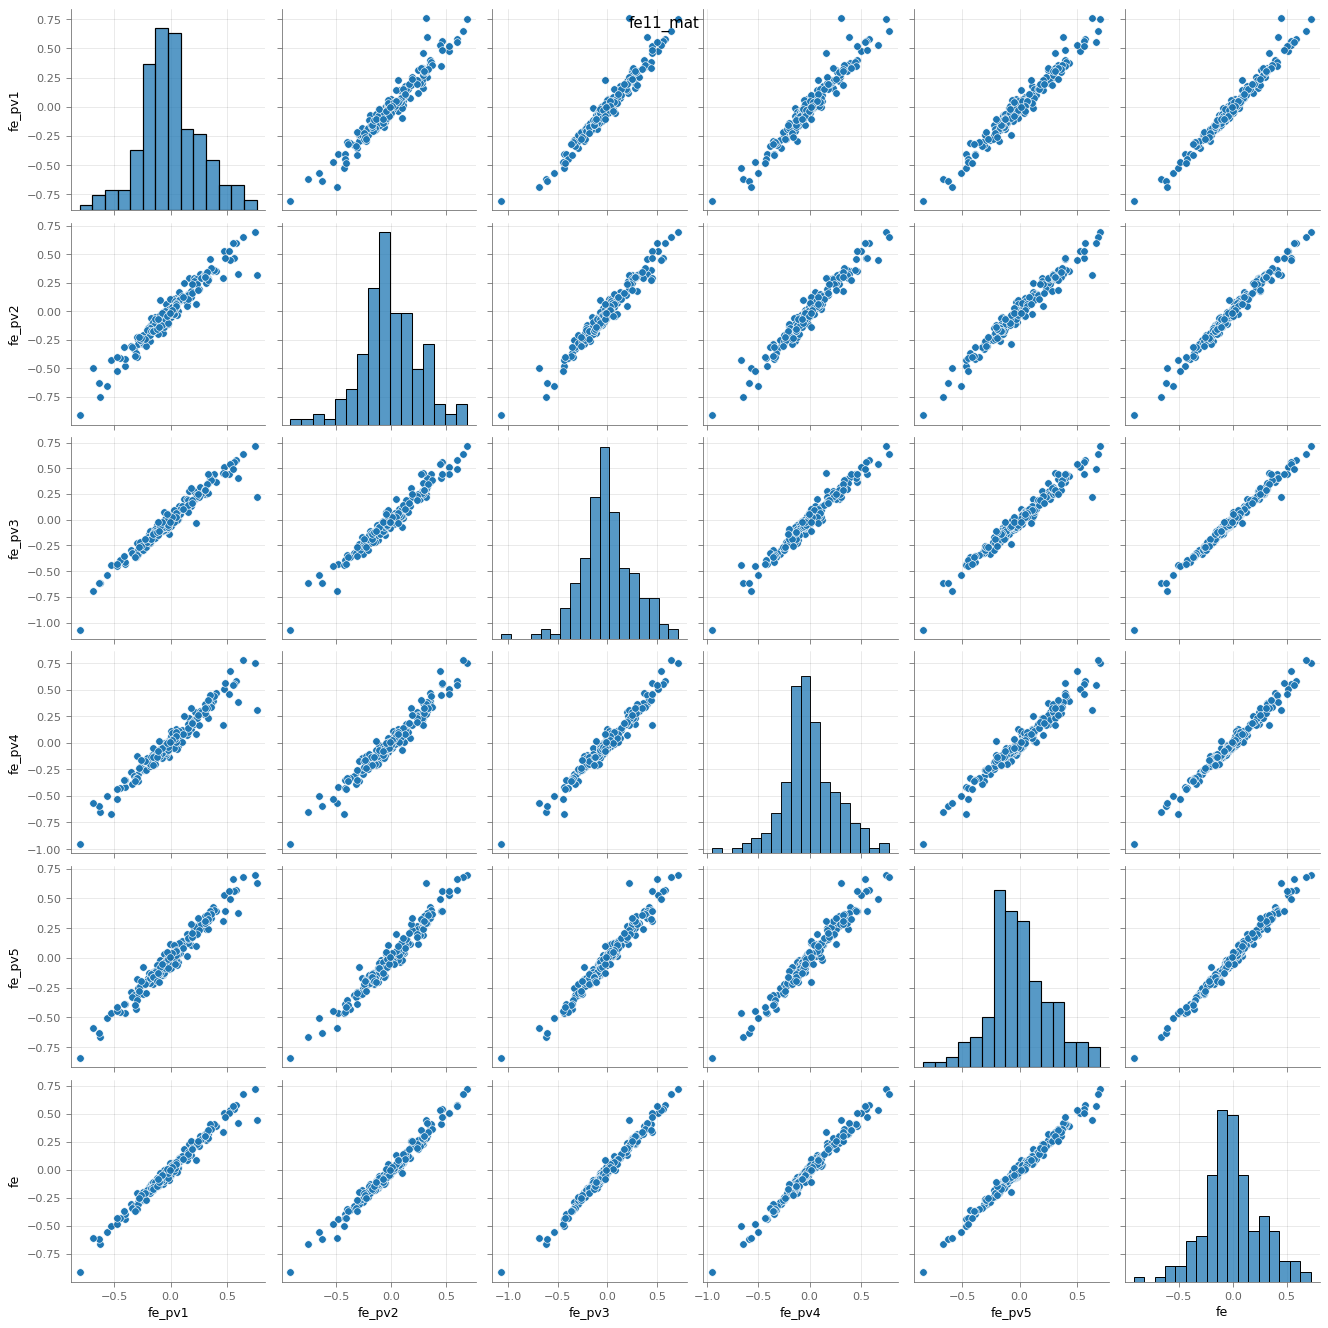

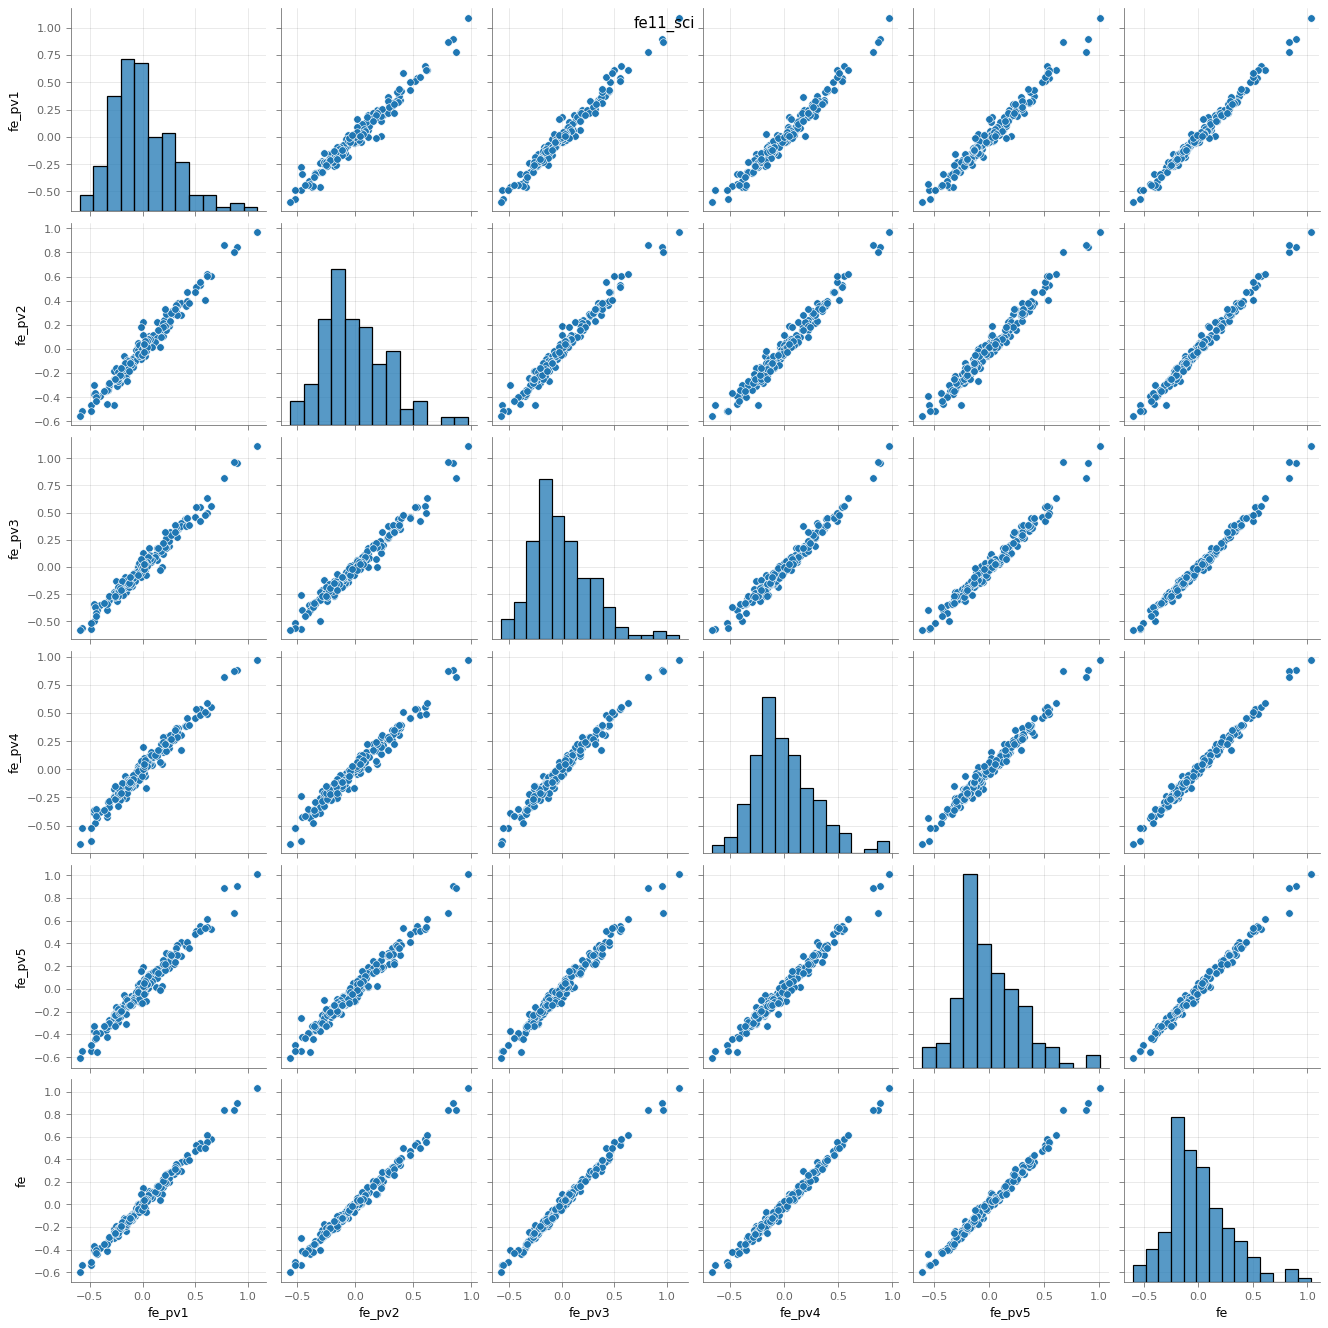

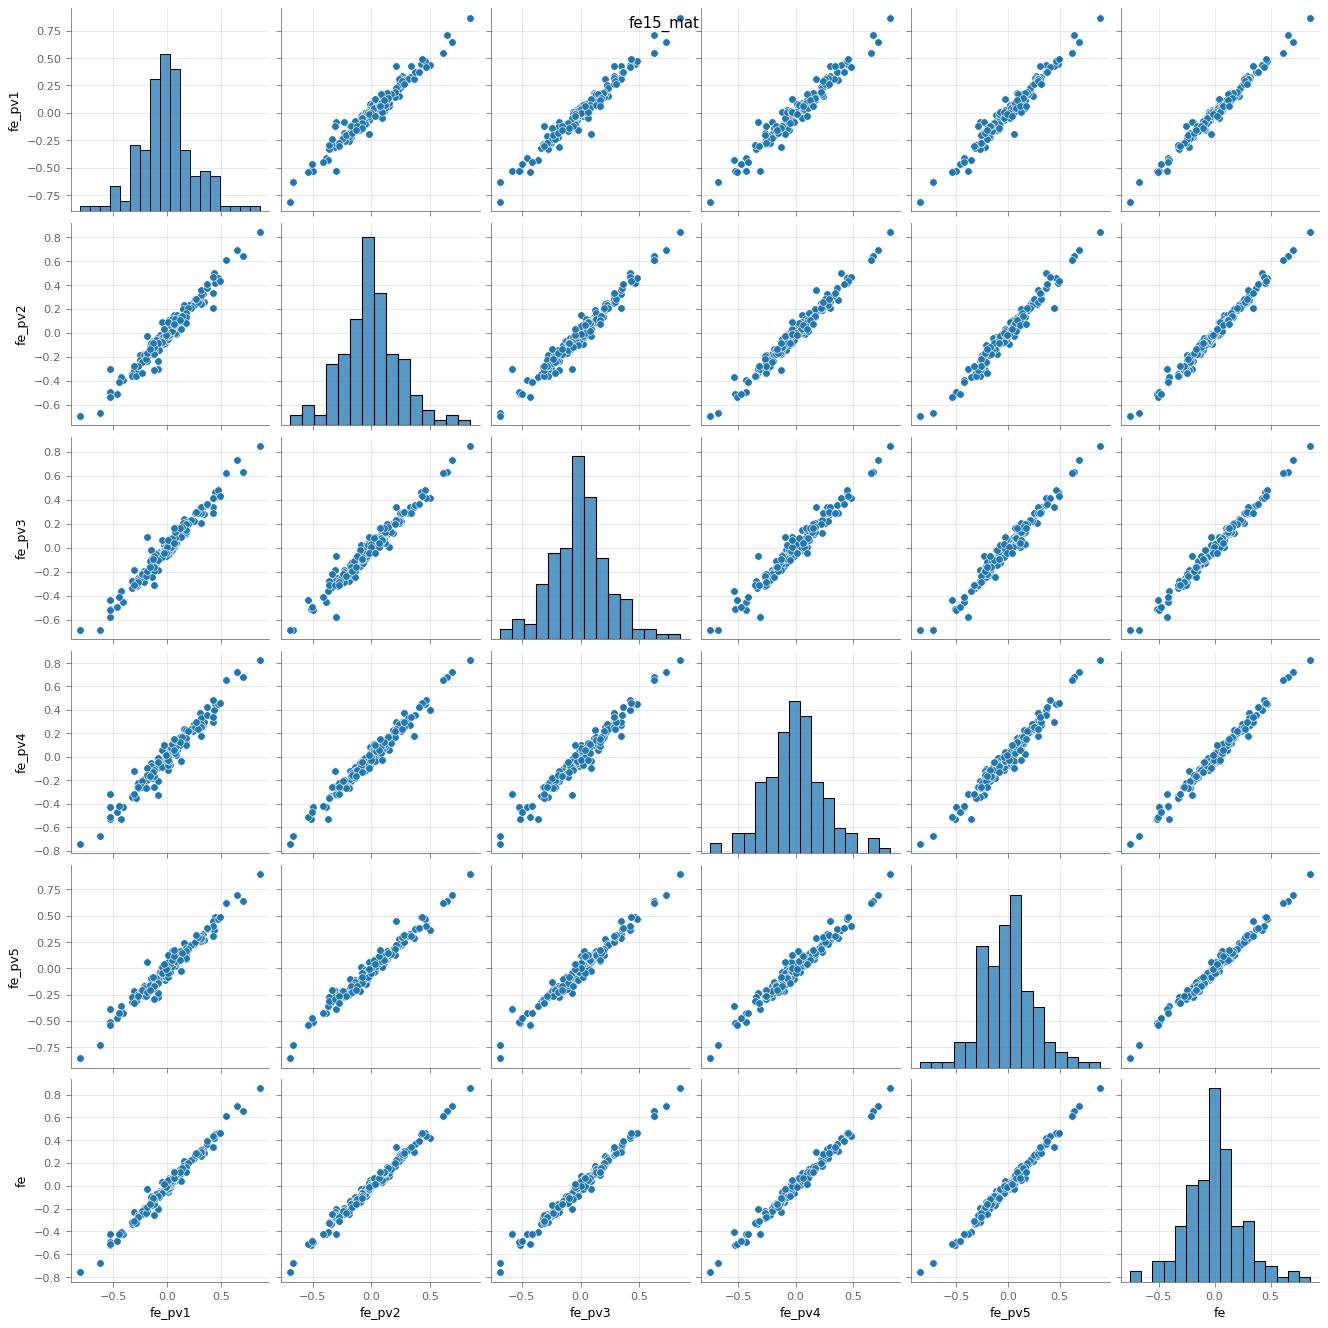

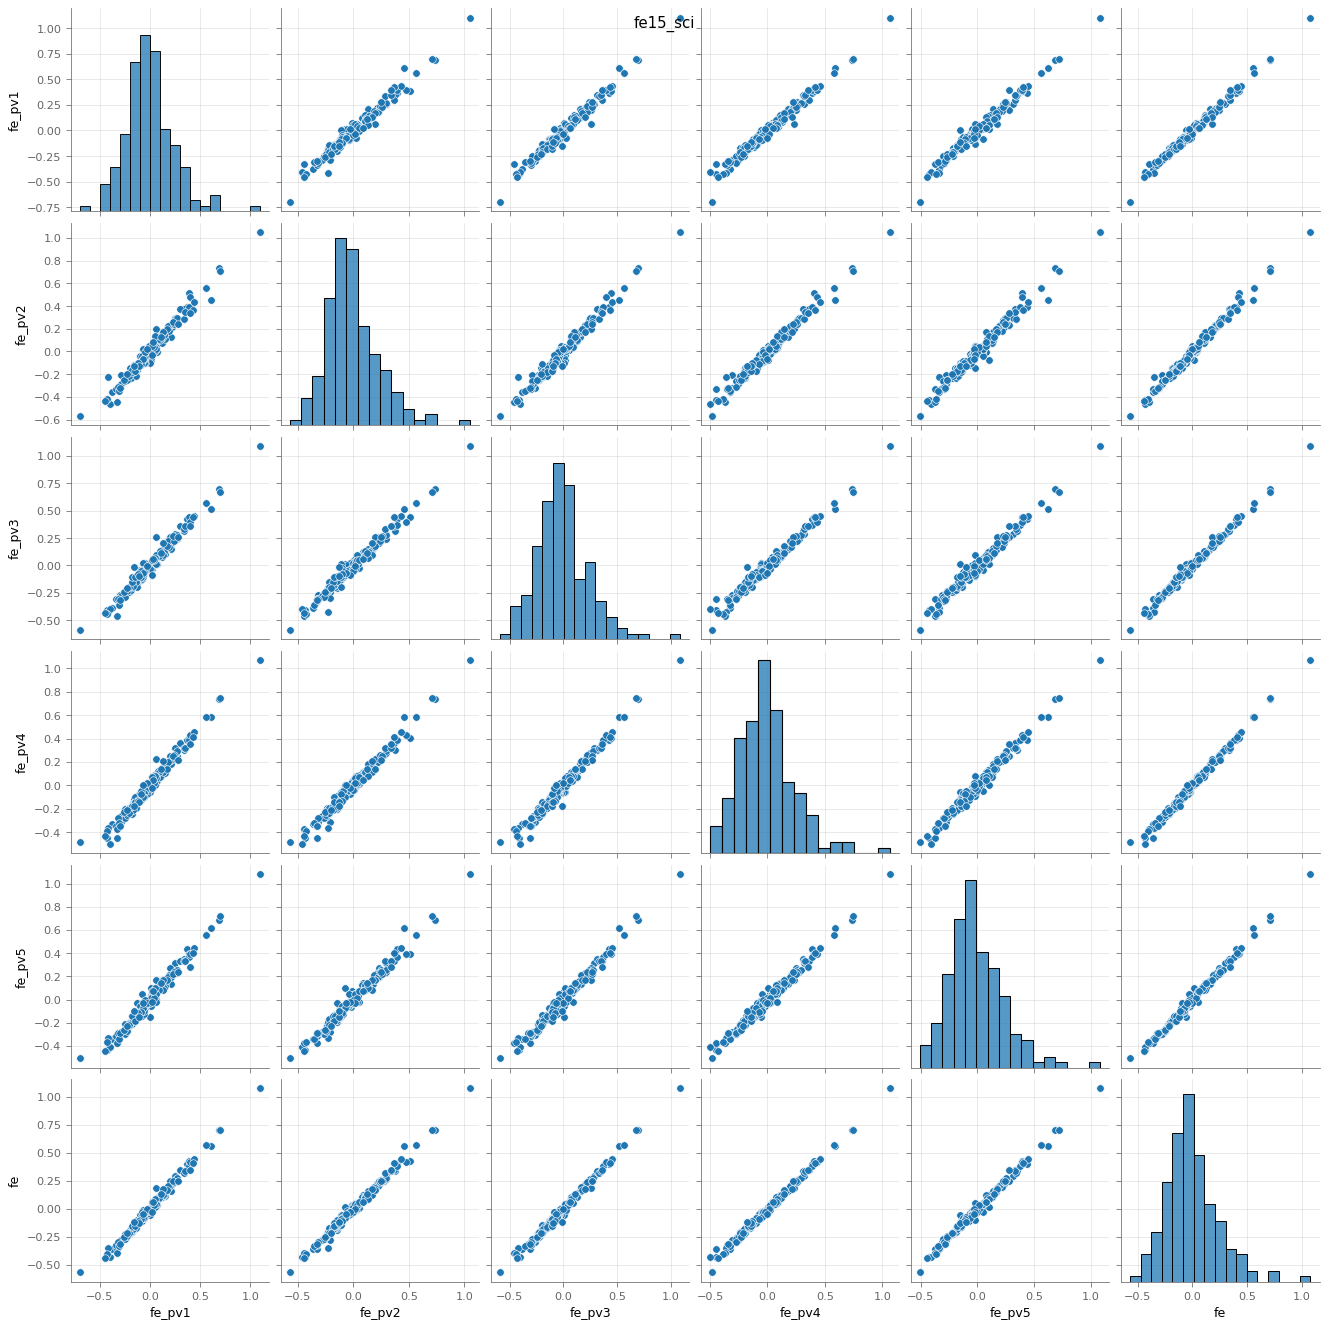

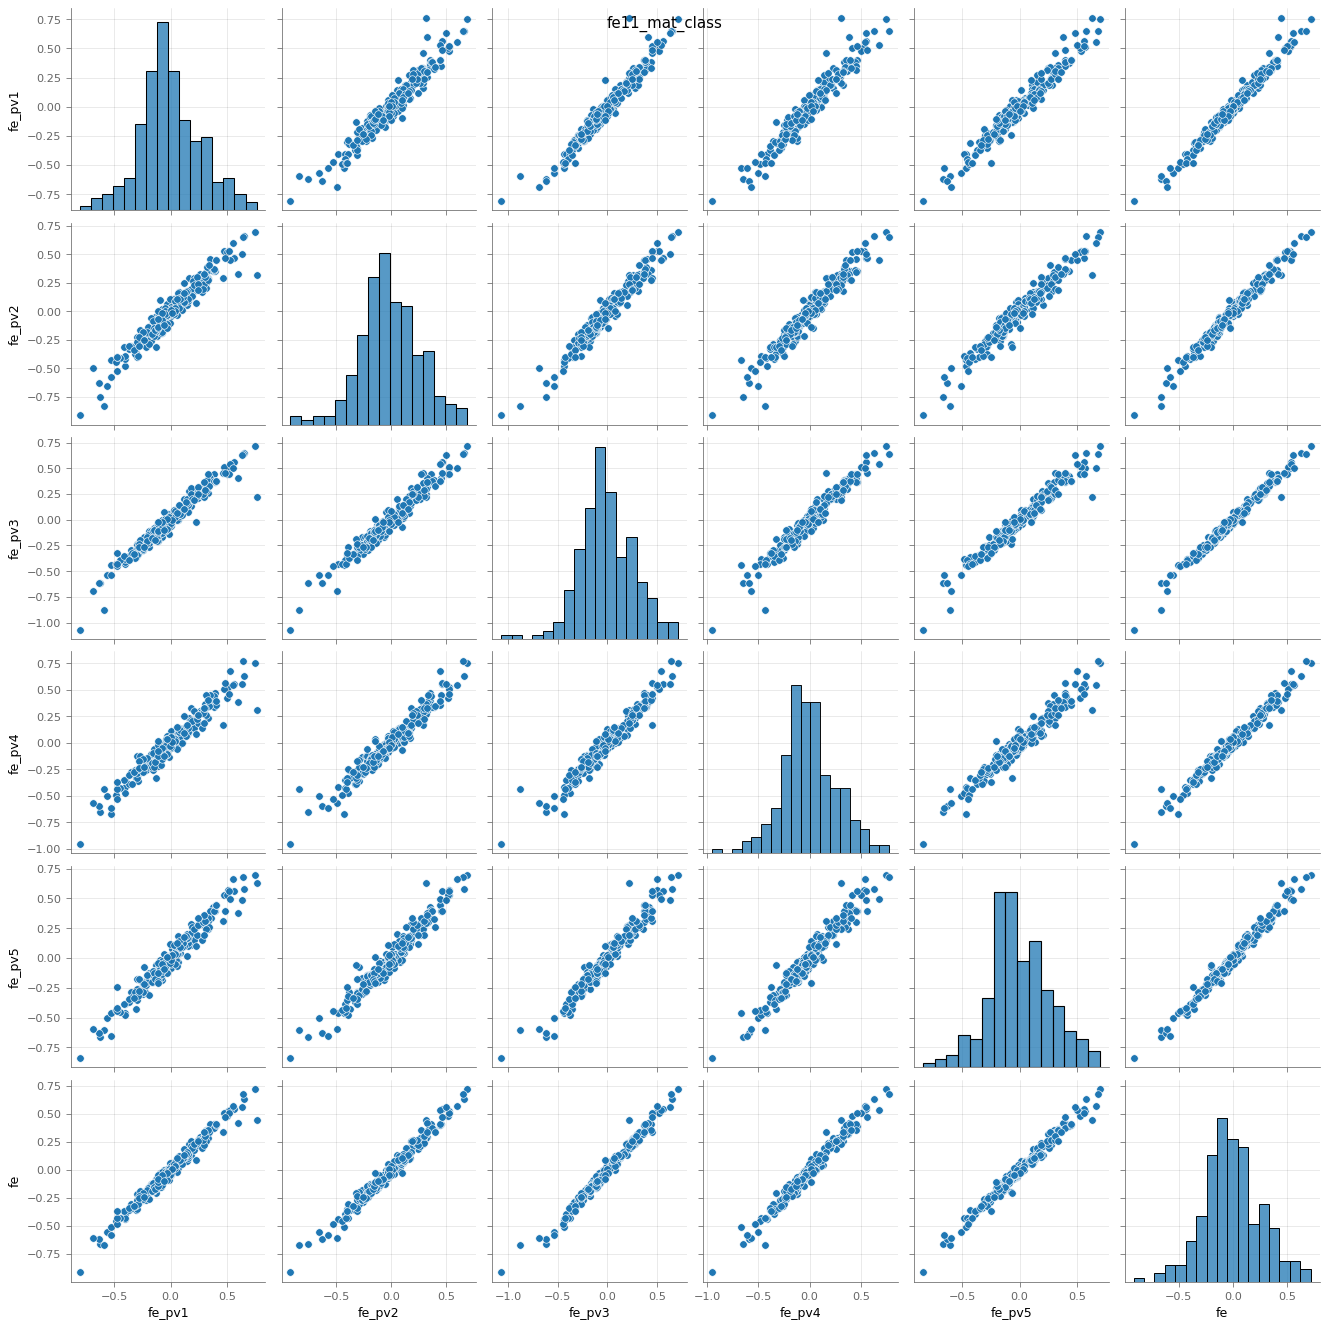

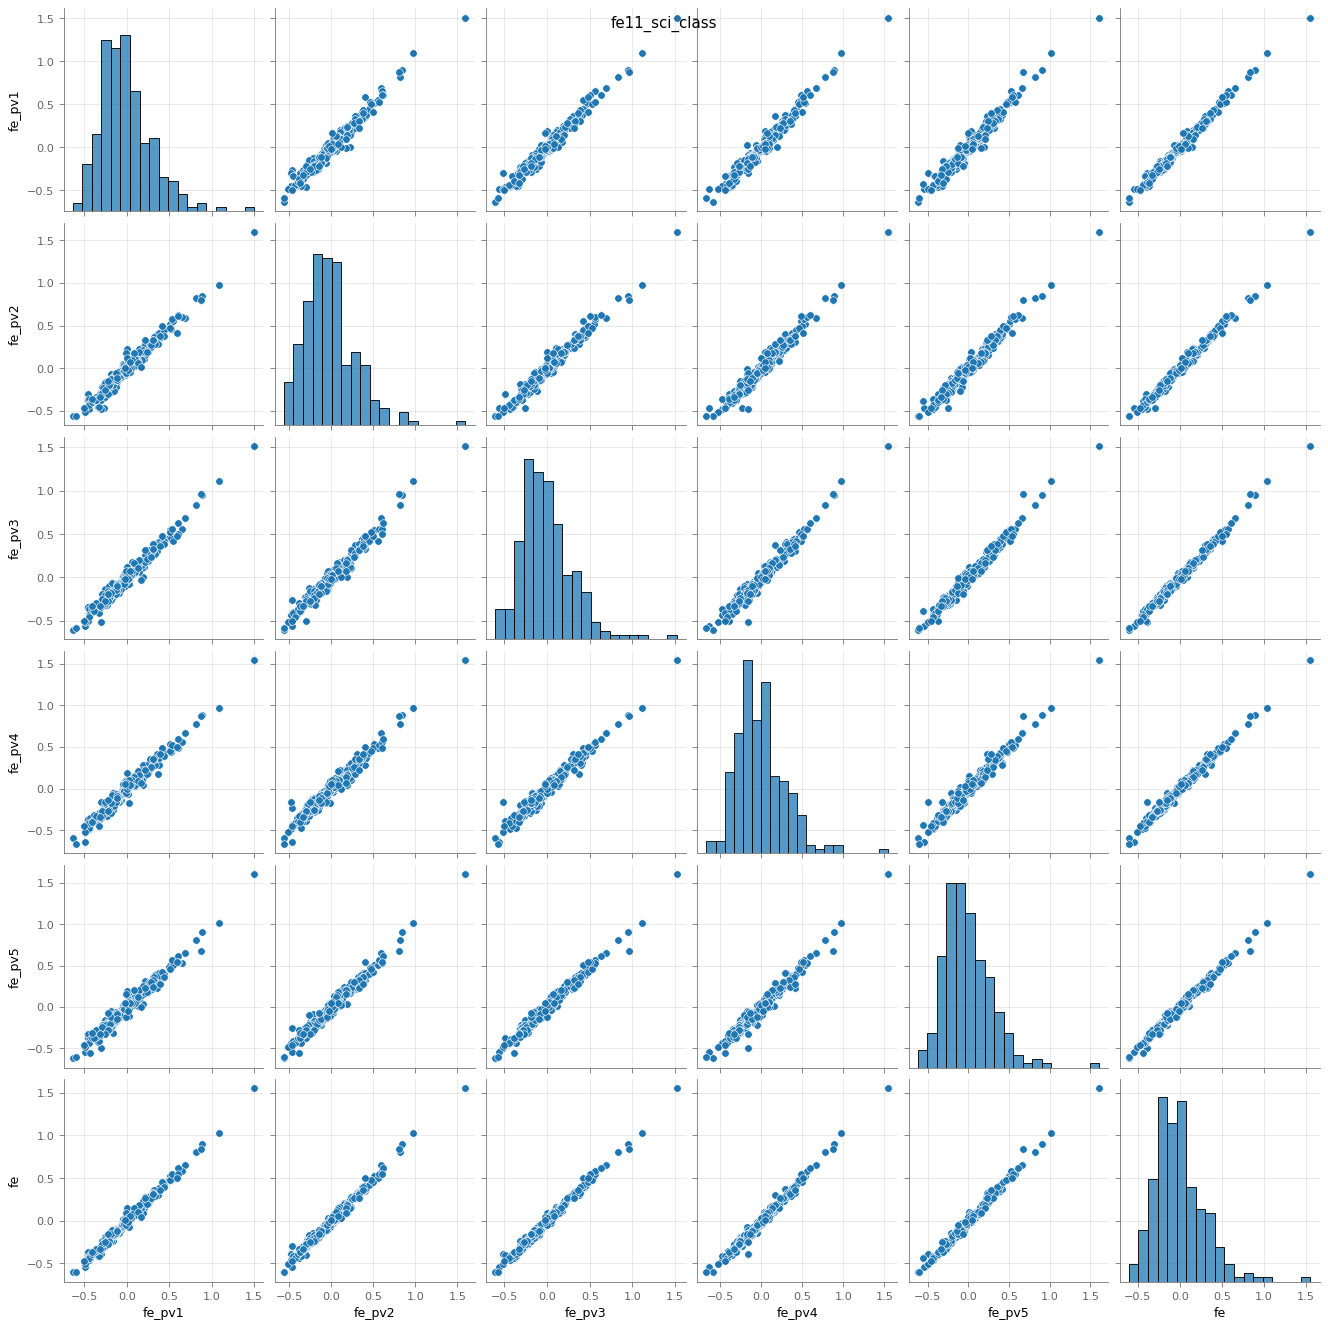

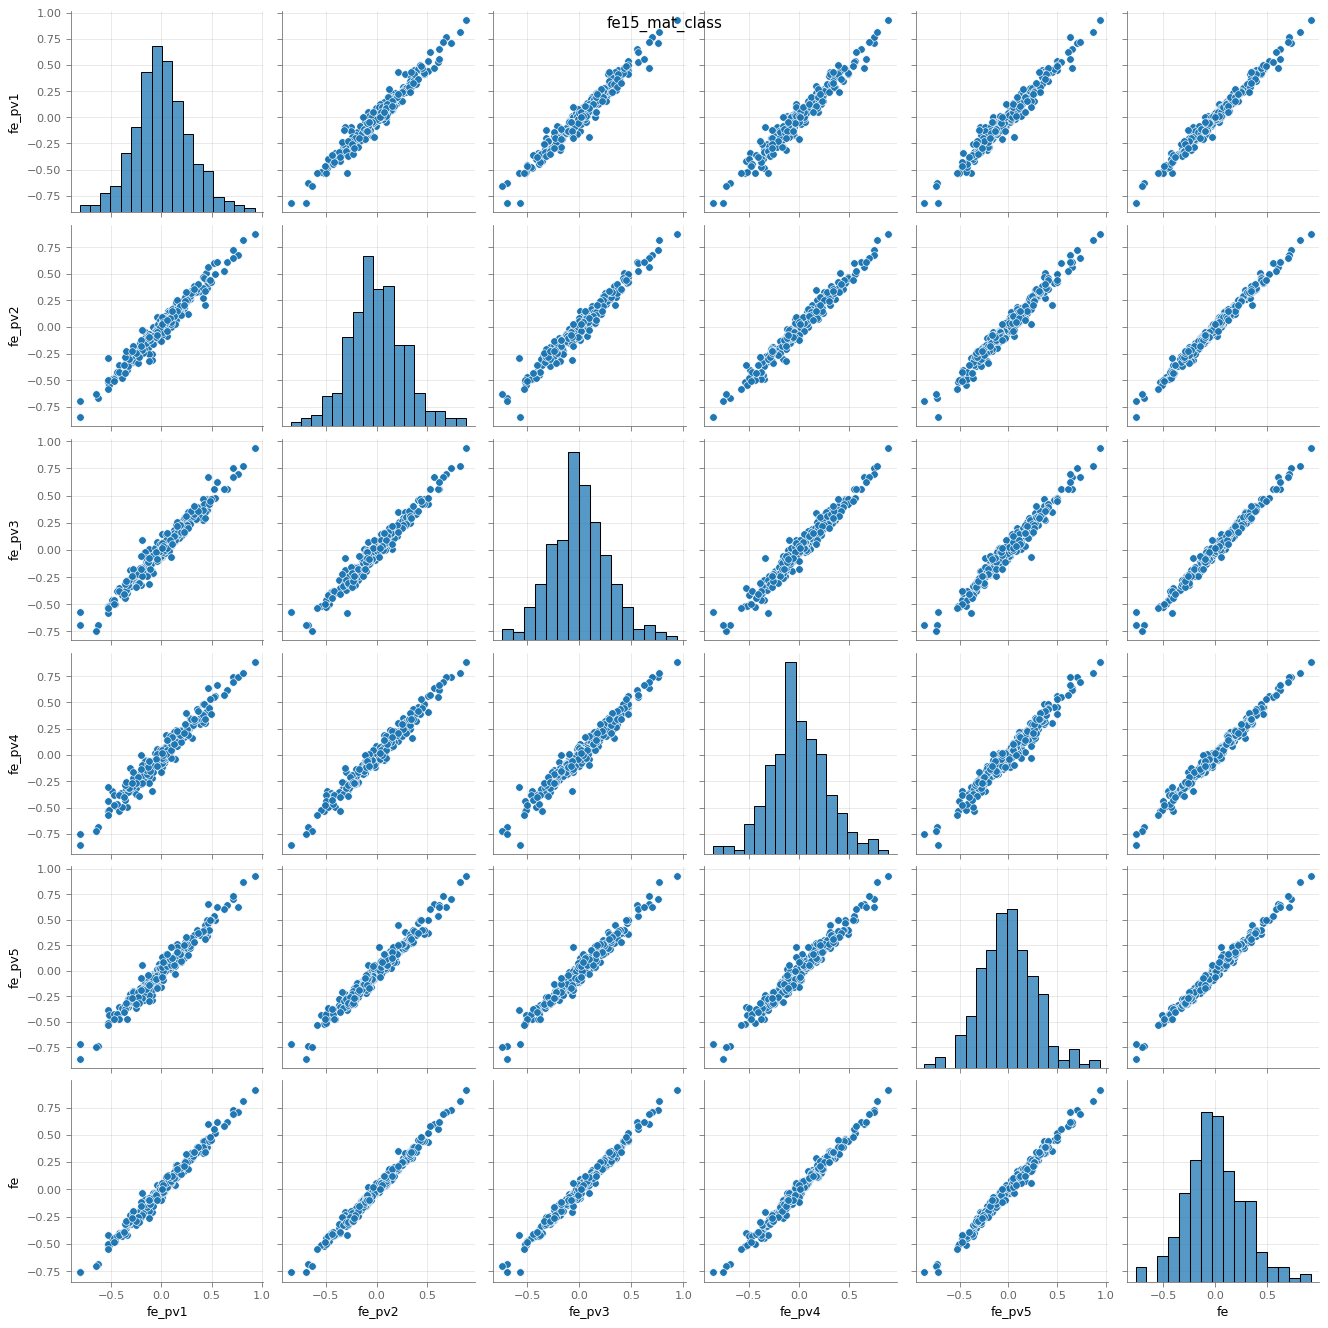

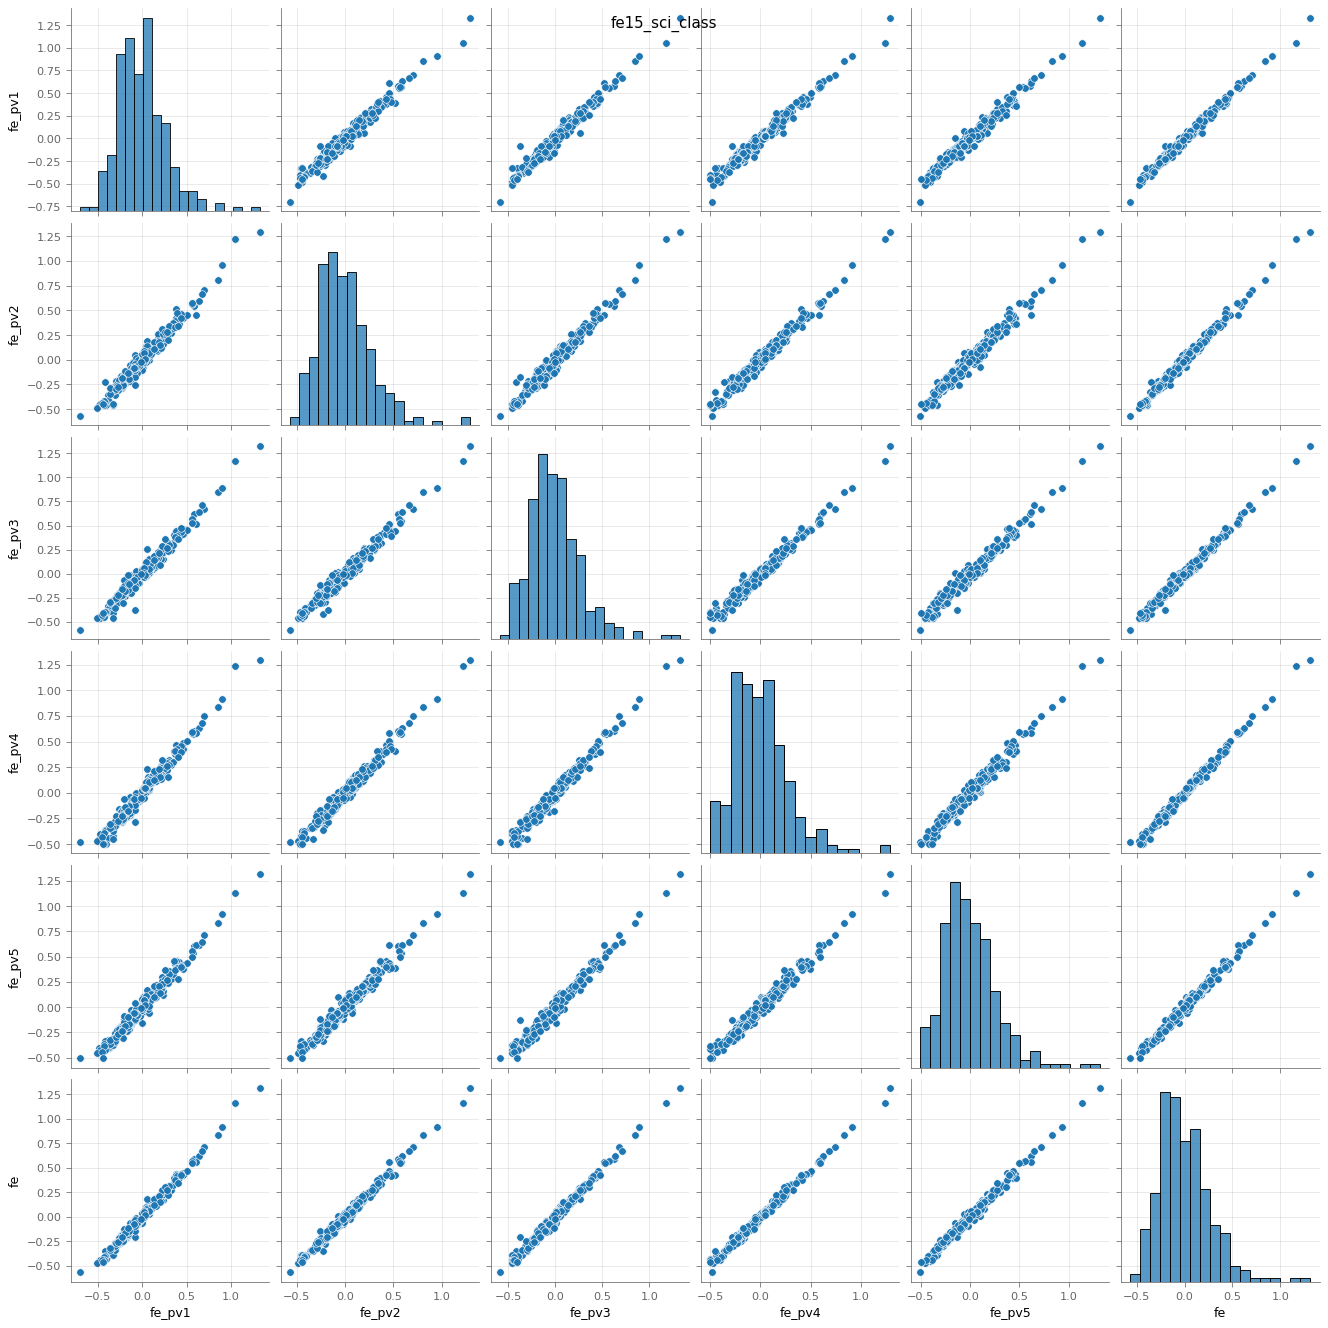

In [33]:
pvs = [f'fe_pv{i}' for i in range(1, 6)] + ['fe']

for sc in ['', '_class']:
    for y in [11, 15]:
        for ms in ['mat', 'sci']:
            fe = f'fe{y}_{ms}{sc}'
            print(fe)
            pp = sns.pairplot(eval(fe)[pvs])
            pp.fig.suptitle(fe)

### Rozložení třídních / školních efektů

Skupinové efekty jsou vyjádřeny v prostoru známek - tzn. školní efekt 0.25 znamená, že žáci s určitým skórem dostávají o 0.25 stupně horší známku než by dostali v průměrné škole (tedy známkování zde je o 0.25 stupně přísnější).

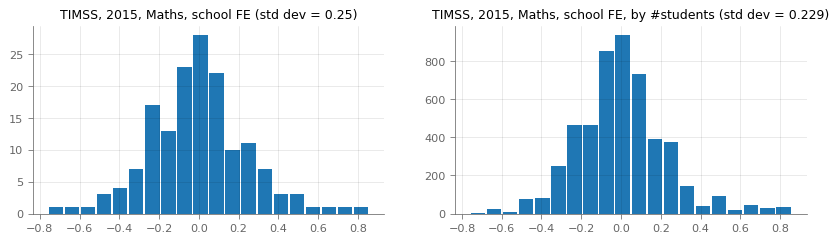

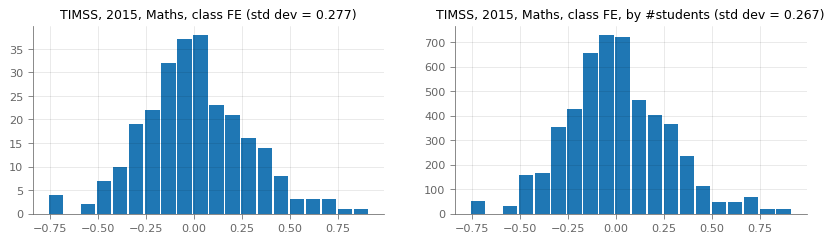

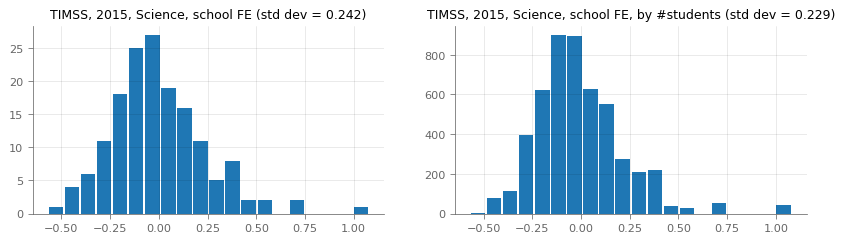

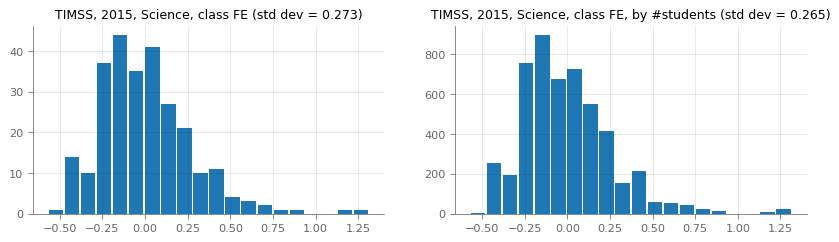

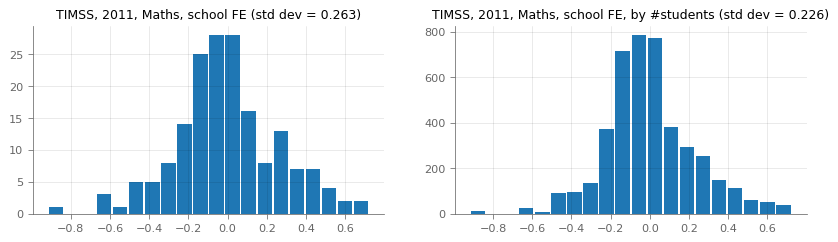

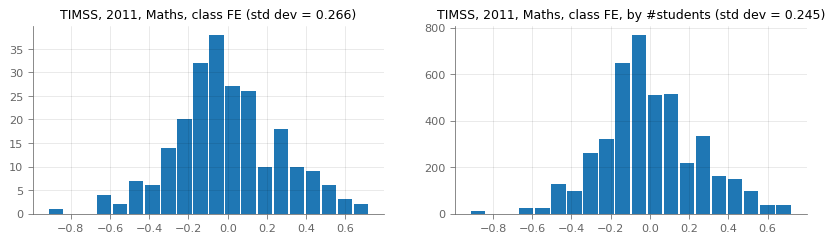

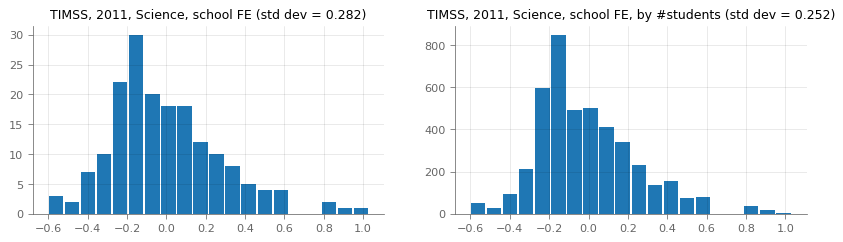

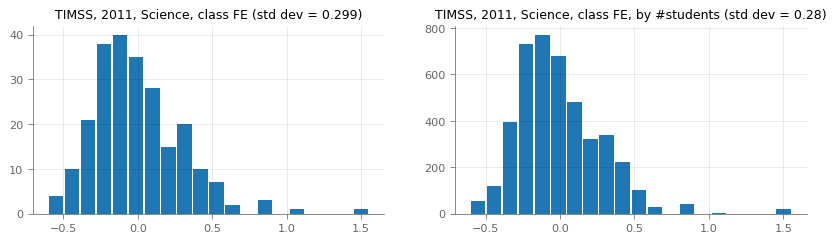

In [15]:
def hist_fe(fe, weights=False, title='', ax=None):
    stat = DescrStatsW(fe['fe'], weights=(fe['count'] if weights else None))
    ax = ax or plt.gca()
    ax.hist(fe['fe'], bins=20, rwidth=0.9, weights=(fe['count'] if weights else None))
    ax.set_title('{} (std dev = {:.3g})'.format(title, stat.std), fontsize=10)
    return ax

plt.rcParams['figure.figsize'] = 10, 2.5

for y in [15, 11]:
    for c in ['mat', 'sci']:
        for g in ['school', 'class']:
            fig, axes = plt.subplots(1, 2)
            for w in [0, 1]:
                fe = eval('fe{}_{}{}'.format(y, c, ('' if g == 'school' else '_class')))
                title = 'TIMSS, 20{}, {}, {} FE{}'.format(y, ('Maths' if c == 'mat' else 'Science'), g,
                    (', by #students' if w else ''))
                hist_fe(fe, w, title, ax=axes[w])                

## Stabilita třídních / školních efektů

Data vykazují poměrně vysokou korelaci mezi skupinovými efekty v matematice a v přírodovědě. Skupiny se tedy pravděpodobně opravdu liší v přísnosti známkování, jen ji nedokážeme dobře vysvětlit pozorovanými atributy.

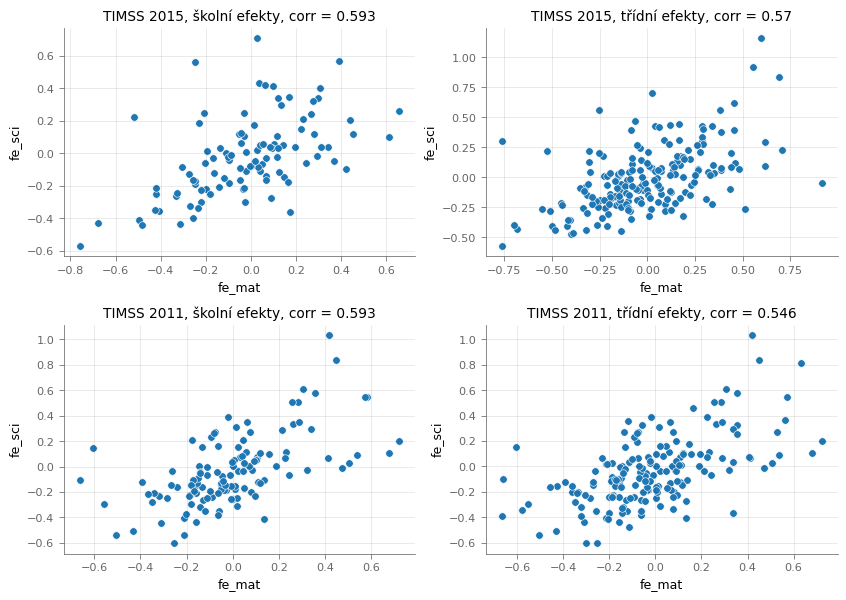

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
plt.subplots_adjust(hspace=0.3)

scol = ['school', 'fe', 'count']
ccol = ['class', 'fe', 'count']

fe15 = pd.merge(fe15_mat[scol].rename(columns={'fe': 'fe_mat'}), fe15_sci[scol].rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe15[['fe_mat', 'fe_sci']], weights=fe15['count'])
sns.scatterplot(data=fe15, x='fe_mat', y='fe_sci', ax=axes[0][0])
axes[0][0].set_title(f'TIMSS 2015, školní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')

fe15_class = pd.merge(fe15_mat_class[ccol].rename(columns={'fe': 'fe_mat'}), fe15_sci_class[ccol].rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe15_class[['fe_mat', 'fe_sci']], weights=fe15_class['count'])
sns.scatterplot(data=fe15_class, x='fe_mat', y='fe_sci', ax=axes[0][1])
axes[0][1].set_title(f'TIMSS 2015, třídní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')

fe11 = pd.merge(fe11_mat[scol].rename(columns={'fe': 'fe_mat'}), fe11_sci[scol].rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe11[['fe_mat', 'fe_sci']], weights=fe11['count'])
sns.scatterplot(data=fe11, x='fe_mat', y='fe_sci', ax=axes[1][0])
axes[1][0].set_title(f'TIMSS 2011, školní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')

fe11_class = pd.merge(fe11_mat_class[ccol].rename(columns={'fe': 'fe_mat'}), fe11_sci_class[ccol].rename(columns={'fe': 'fe_sci'}))
dsw = DescrStatsW(fe11_class[['fe_mat', 'fe_sci']], weights=fe11_class['count'])
sns.scatterplot(data=fe11_class, x='fe_mat', y='fe_sci', ax=axes[1][1])
axes[1][1].set_title(f'TIMSS 2011, třídní efekty, corr = {dsw.corrcoef[0, 1]:.3g}')
None

## Školní efekty v závislosti na sídle / charakteristikách školy

Některé grafy naznačují rozdíly podle charakteristik, avšak nikdy nelze tento efekt pozorovat v obou předmětech a u obou ročníků. Může se tedy jednat spíše o náhodný šum než o skutečný efekt. Některé školy pravděpodobně jsou přísnější, avšak nemusí se jednat o systematické tendence způsobené pozorovanými charakteristikami škol a obce.

In [21]:
def compare_fe(cg, cg_meta, var, col, label, num_labels, left=0.16, title=None, fe_col='fe'):
    labels = [cg_meta.value_labels[label][x] for x in range(1, num_labels + 1)]
    cg[var] = pd.Categorical(cg[col].apply(lambda x: None if not np.isfinite(x)
        else cg_meta.value_labels[label][x]), labels, ordered=True)
    plt.rcParams['figure.figsize'] = 7, 2.5
    plt.rcParams['figure.subplot.left'] = left
    fig, ax = plt.subplots()
    sns.boxplot(y=var, x=fe_col, data=cg)
    if title is not None:
        ax.set_title(title)
    return ax

def compare_fe_all(cg, cg_meta, vars, cols, labels, num_labels, lefts, title):
    plots = []
    for v, c, l, nl, left in zip(vars, cols, labels, num_labels, lefts):
        ax = compare_fe(cg, cg_meta, v, c, l, nl, left=left)
        ax.set_title(title.format(v))
        plots.append(ax)
    return plots

In [22]:
vars = ['population', 'area', 'poor', 'affluent']
cols = ['ACBG05A', 'ACBG05B', 'ACBG03A', 'ACBG03B']
labels = ['labels{}'.format(i) for i in [5, 6, 2, 3]]
num_labels15 = [7, 5, 4, 4]
num_labels11 = [6, 5, 4, 4]
lefts15 = [0.16, 0.33, 0.16, 0.16]
lefts11 = [0.24, 0.16, 0.16, 0.16]

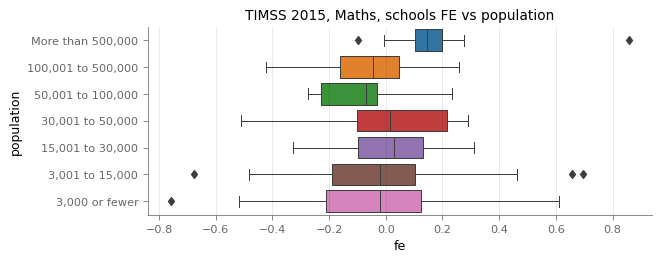

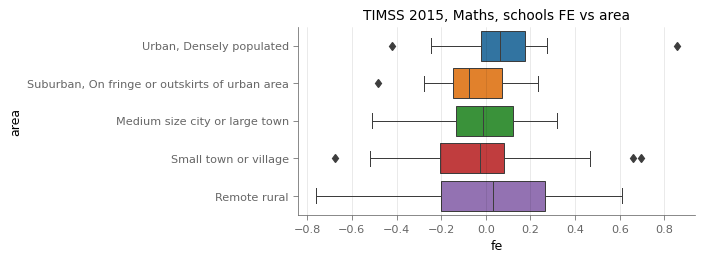

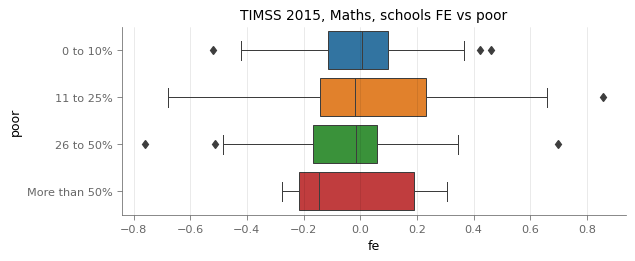

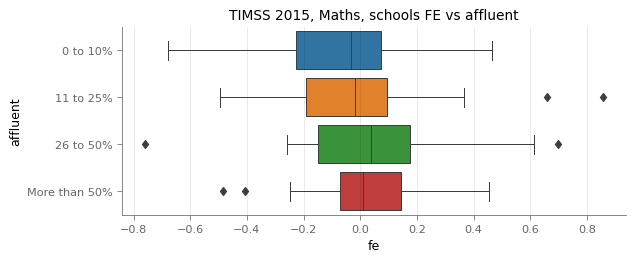

In [23]:
plots15_mat = compare_fe_all(pd.merge(cg15, fe15_mat), cg15_meta, vars, cols, labels, num_labels15, lefts15,
    title='TIMSS 2015, Maths, schools FE vs {}')

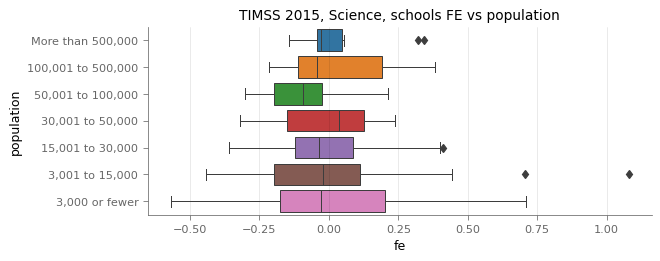

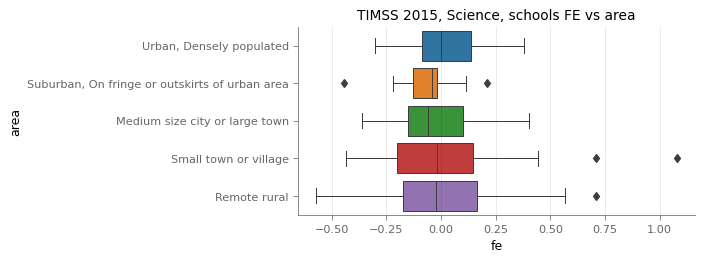

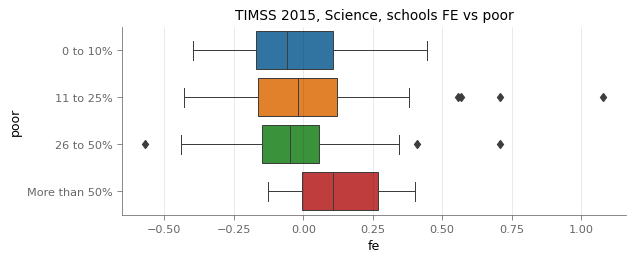

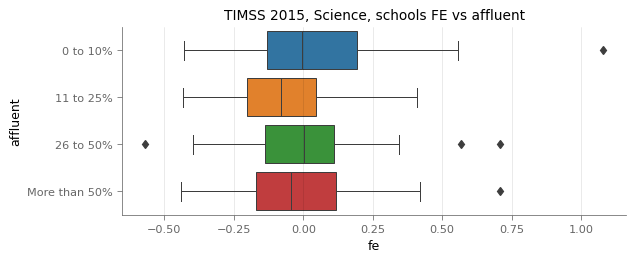

In [24]:
plots15_sci = compare_fe_all(pd.merge(cg15, fe15_sci), cg15_meta, vars, cols, labels, num_labels15, lefts15,
    title='TIMSS 2015, Science, schools FE vs {}')

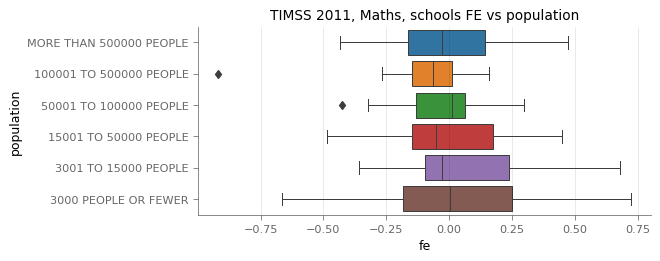

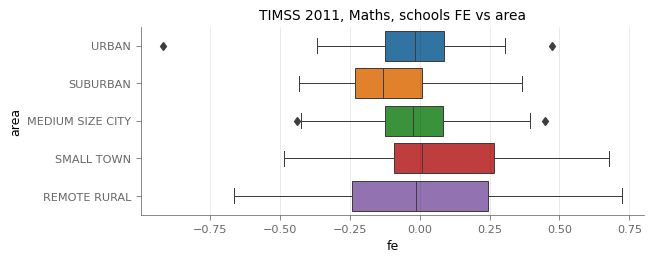

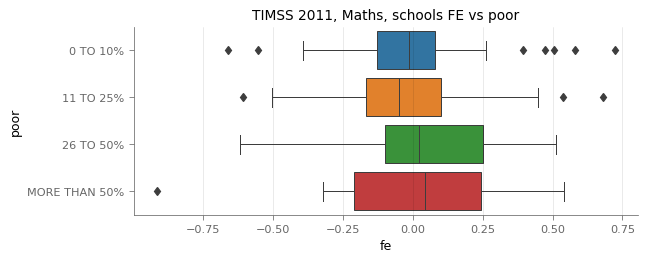

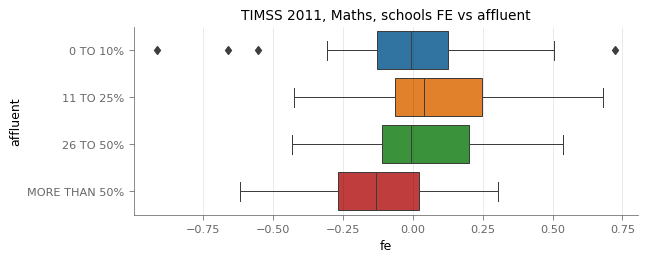

In [25]:
plots11_mat = compare_fe_all(pd.merge(cg11, fe11_mat), cg11_meta, vars, cols, labels, num_labels11, lefts11,
    title='TIMSS 2011, Maths, schools FE vs {}')

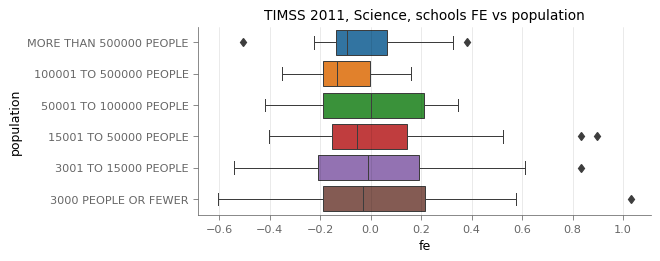

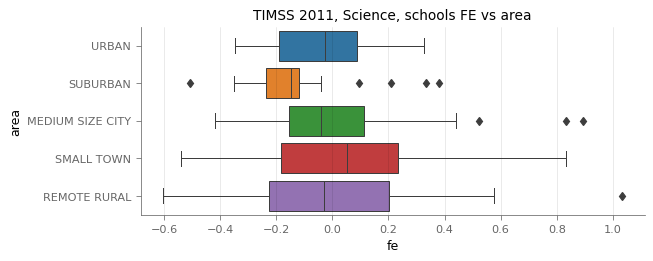

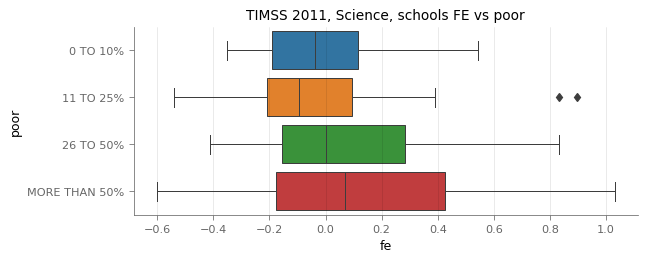

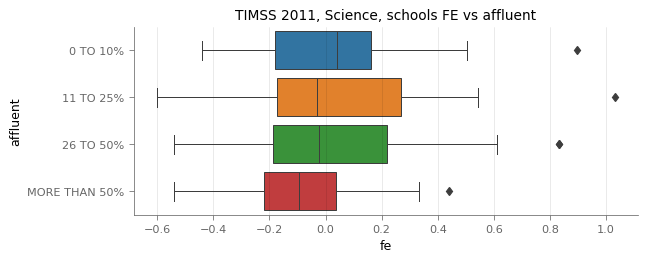

In [26]:
plots11_sci = compare_fe_all(pd.merge(cg11, fe11_sci), cg11_meta, vars, cols, labels, num_labels11, lefts11,
    title='TIMSS 2011, Science, schools FE vs {}')

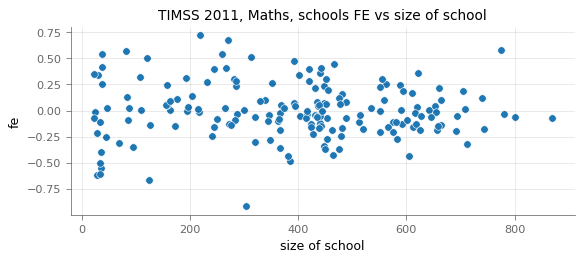

In [27]:
_, size11_mat = plt.subplots()
sns.scatterplot(x='ACBG01', y='fe', data=pd.merge(cg11, fe11_mat))
size11_mat.set(xlabel='size of school')
size11_mat.set_title('TIMSS 2011, Maths, schools FE vs size of school')
None

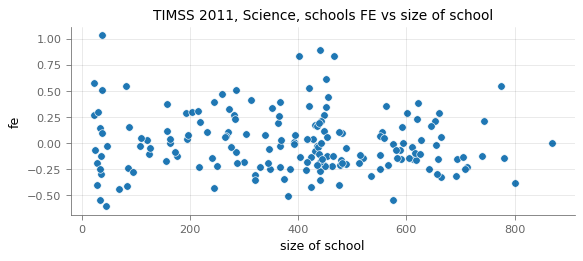

In [28]:
_, size11_sci = plt.subplots()
sns.scatterplot(x='ACBG01', y='fe', data=pd.merge(cg11, fe11_sci))
size11_sci.set(xlabel='size of school')
size11_sci.set_title('TIMSS 2011, Science, schools FE vs size of school')
None